# Classificação multiclasse

Para realizar nossos experimentos escolhemos uma base de dados de feijões secos, a qual possui 7 classes distintas

In [1]:
import pandas as pd

data_path = '../data/Dry_Bean_Dataset.xlsx'
beans_data = pd.read_excel(data_path)

sample = beans_data.sample(3)
print(sample)

       Bean ID   Area  Perimeter  MajorAxisLength  MinorAxisLength  \
12632    12633  35168    698.453       250.556503       179.747876   
9031      9032  45849    803.351       300.558016       195.158812   
12321    12322  33796    689.612       257.021439       167.856611   

       AspectRation  Eccentricity  ConvexArea  EquivDiameter    Extent  \
12632      1.393933      0.696667       35615     211.606447  0.712624   
9031       1.540069      0.760514       46301     241.612831  0.700894   
12321      1.531196      0.757285       34210     207.437710  0.696581   

       Solidity  roundness  Compactness  ShapeFactor1  ShapeFactor2  \
12632  0.987449   0.905906     0.844546      0.007125      0.002236   
9031   0.990238   0.892748     0.803881      0.006555      0.001689   
12321  0.987898   0.893029     0.807083      0.007605      0.001990   

       ShapeFactor3  ShapeFactor4     Class  
12632      0.713258      0.994233  DERMASON  
9031       0.646224      0.995230      SIRA  

Devemos tirar todos os atributos da base que são considerados irrelevantes. Nesse caso, retiramos Beans ID. 

In [2]:
X = beans_data.iloc[:,1:-1]
y = beans_data.Class

print(X.sample(1))

       Area  Perimeter  MajorAxisLength  MinorAxisLength  AspectRation  \
5052  80507   1078.504       423.370841        243.36674      1.739641   

      Eccentricity  ConvexArea  EquivDiameter    Extent  Solidity  roundness  \
5052      0.818272       81055     320.163546  0.774299  0.993239   0.869761   

      Compactness  ShapeFactor1  ShapeFactor2  ShapeFactor3  ShapeFactor4  
5052     0.756225      0.005259      0.001061      0.571876      0.994859  


Após ler nossos dados, precisamos dividi-los em dados de teste e dados de treinamento. Além disso, também vamos normalizar os nossos dados

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=16)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Método One versus Rest

Primeiramente o grupo testou o classificador OneVsRestClassifier da biblioteca sklearn

In [4]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=13)

ovr = OneVsRestClassifier(model)

ovr.fit(X_train,y_train)

y_pred = ovr.predict(X_test)

Mostrando os resultados do modelo

In [5]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(classification_report(y_test, y_pred))
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

    BARBUNYA       0.95      0.86      0.90       331
      BOMBAY       1.00      1.00      1.00       121
        CALI       0.90      0.96      0.93       408
    DERMASON       0.92      0.93      0.92       874
       HOROZ       0.94      0.94      0.94       470
       SEKER       0.96      0.96      0.96       513
        SIRA       0.87      0.87      0.87       686

    accuracy                           0.92      3403
   macro avg       0.93      0.93      0.93      3403
weighted avg       0.92      0.92      0.92      3403

Confusion matrix:
[[285   0  28   0   3   2  13]
 [  0 121   0   0   0   0   0]
 [  8   0 390   0   7   0   3]
 [  0   0   0 809   0  14  51]
 [  1   0  13   2 442   0  12]
 [  2   0   0   8   0 491  12]
 [  3   0   0  65  16   6 596]]


O grupo optou por fazer a própria implementação do método

Criação dos modelos

In [6]:
import numpy as np

models = []

for label in np.unique(y):
    filter = lambda r:(1 if r == label else -1)
    y_train_class = np.array([filter(row) for row in y_train])
    y_test_class = np.array([filter(row) for row in y_test])

    model = KNeighborsClassifier(n_neighbors=13)
    model.fit(X_train,y_train_class)
    models.append((model,label))

Predição

In [7]:
y_pred = np.empty(len(y_test), dtype='O')
max_prob = np.zeros(len(y_train))

for model in models:
    probability = model[0].predict_proba(X_test)[:,1]
    for i,prob in enumerate(probability):
        if max_prob[i] <= prob:
            max_prob[i] = prob
            y_pred[i] = model[1]

Resultados

In [8]:
print(classification_report(y_test, y_pred))
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

    BARBUNYA       0.95      0.86      0.90       331
      BOMBAY       1.00      1.00      1.00       121
        CALI       0.90      0.96      0.93       408
    DERMASON       0.92      0.93      0.92       874
       HOROZ       0.94      0.94      0.94       470
       SEKER       0.96      0.96      0.96       513
        SIRA       0.87      0.87      0.87       686

    accuracy                           0.92      3403
   macro avg       0.93      0.93      0.93      3403
weighted avg       0.92      0.92      0.92      3403

Confusion matrix:
[[285   0  28   0   3   2  13]
 [  0 121   0   0   0   0   0]
 [  8   0 390   0   7   0   3]
 [  0   0   0 809   0  14  51]
 [  1   0  13   2 442   0  12]
 [  2   0   0   8   0 491  12]
 [  3   0   0  65  16   6 596]]


Vamos testar o algoritmo com tipos diferentes de modelos

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


modelos = [
    ('Decision Tree', DecisionTreeClassifier()),
    ('KNN', KNeighborsClassifier(n_neighbors=13)),
    ('Logistic Regression', LogisticRegression(max_iter=300)),
    ('Naive Bayes', GaussianNB())
]

# Lista para armazenar as acurácias de cada modelo
acuracias = []

# Treine e avalie cada modelo
for nome, modelo in modelos:
    ovr = OneVsRestClassifier(modelo)
    ovr.fit(X_train, y_train)
    y_pred = ovr.predict(X_test)
    acuracia = accuracy_score(y_test, y_pred)
    acuracias.append((nome, acuracia))

Vamos plotar o resultado

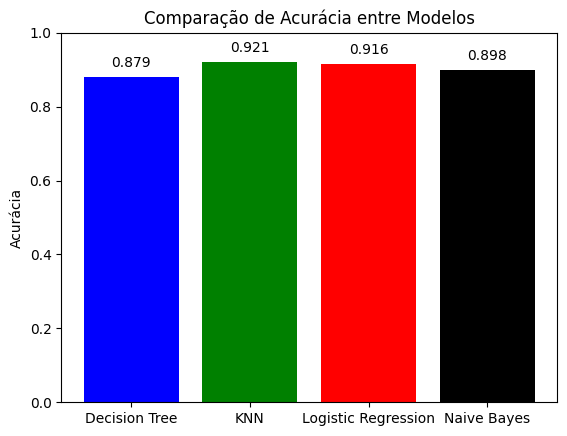

In [10]:
import matplotlib.pyplot as plt

nomes_modelos, valores_acuracia = zip(*acuracias)
barras = plt.bar(nomes_modelos, valores_acuracia, color=['blue', 'green', 'red', 'black'])  # Adicione mais cores conforme necessário

for barra in barras:
        altura = barra.get_height()
        plt.text(barra.get_x() + barra.get_width() / 2, altura + 0.02, f'{altura:.3f}', ha='center', va='bottom')
plt.ylabel('Acurácia')
plt.title('Comparação de Acurácia entre Modelos')
plt.ylim(0, 1)  # Defina o limite y de 0 a 1 para a acurácia
plt.show()

## Método One versus One

### Adaptive Directed Acyclic Graph 

O grupo implementou não encontrou uma biblioteca que implementasse o ADAG, logo optamos por implementa-lo

Variaveis

In [11]:
class_array = np.unique(y)
X_train_array = np.array(X_train)
y_train_array = np.array(y_train)
X_test_array = np.array(X_test)
lables_data = []
models = np.empty((len(class_array),len(class_array)), dtype='O')
y_pred = np.empty(len(y_test), dtype='O')

Separação dos dados de cada classe

In [12]:
for i,label in enumerate(class_array):
    data = np.array([row for index,row in enumerate(X_train_array) if y_train_array[index] == label])
    lables_data.append(data)

Função de criação dos modelos

In [13]:
def createModels(class_array, model):

    models = np.empty((len(class_array),len(class_array)), dtype='O')
    
    for i in range(len(class_array)):
        for j in range(i+1,len(class_array)):
            x_train_class = []
            for row in lables_data[i]:
                x_train_class.append(row)
            for row in lables_data[j]:
                x_train_class.append(row)


            y_train_class = [1]*len(lables_data[i]) + [0]*len(lables_data[j])
            model = copy.deepcopy(model)
            model.fit(np.array(x_train_class),np.array(y_train_class))
            models[i][j] = model
            models[j][i] = -1

    return models

Função utlizada para gerar a ordem da primeira camada do ADAG

In [14]:
def initialLevel(n_labels):
    first = 0
    second = (n_labels - 1) - n_labels%2
    level = []

    while(first < second):
        level.append(first)
        level.append(second)
        first+=1
        second-=1

    if n_labels%2 > 0:
        level.append(n_labels-1)

    return level


Função de predição das classes

In [15]:
import copy

def predict(X_test_array, class_array, models):
    y_pred = np.empty(len(X_test_array), dtype='O')

    for i,row in enumerate(X_test_array):
        levelLabels = initialLevel(len(class_array))

        while len(levelLabels) != 1:
            next_level = []

            for idx in range(0,len(levelLabels)-1 - (len(levelLabels)%2),2):
                first = min(levelLabels[idx],levelLabels[idx+1])
                second = max(levelLabels[idx],levelLabels[idx+1])

                predicao = models[first][second].predict([row])
                if predicao[0] == 1:
                    next_level.append(first)
                else:
                    next_level.append(second)

            if len(levelLabels)%2 > 0:
                next_level.append(levelLabels[len(levelLabels)-1])



            levelLabels = copy.deepcopy(next_level)

        y_pred[i] = class_array[levelLabels[0]]

    return y_pred

Resultados

In [16]:
models = createModels(class_array,LogisticRegression(max_iter=300))
y_pred = predict(X_test_array,class_array,models)

print(classification_report(y_test, y_pred))
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

    BARBUNYA       0.93      0.89      0.91       331
      BOMBAY       1.00      1.00      1.00       121
        CALI       0.92      0.95      0.93       408
    DERMASON       0.91      0.93      0.92       874
       HOROZ       0.94      0.95      0.95       470
       SEKER       0.96      0.96      0.96       513
        SIRA       0.88      0.86      0.87       686

    accuracy                           0.92      3403
   macro avg       0.93      0.93      0.93      3403
weighted avg       0.92      0.92      0.92      3403

Confusion matrix:
[[295   0  23   0   2   1  10]
 [  0 121   0   0   0   0   0]
 [ 12   0 386   0   7   1   2]
 [  1   0   0 812   0   9  52]
 [  1   0  10   4 447   0   8]
 [  5   0   0   8   0 490  10]
 [  2   0   0  68  19   9 588]]


Comparando a acuracia

In [17]:
algoritmos = [
    ('Decision Tree', DecisionTreeClassifier()),
    ('KNN', KNeighborsClassifier(n_neighbors=13)),
    ('Logistic Regression', LogisticRegression()),
    ('Naive Bayes', GaussianNB())
]

acuracias = []

for nome, algoritmo in algoritmos:
    models = createModels(class_array,algoritmo)
    y_pred = predict(X_test_array,class_array,models)
    acuracia = accuracy_score(y_test, y_pred)
    acuracias.append((nome, acuracia))

Plotando

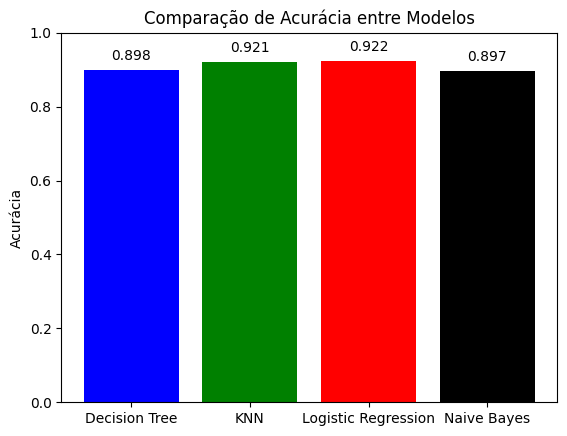

In [18]:
nomes_modelos, valores_acuracia = zip(*acuracias)
plt.bar(nomes_modelos, valores_acuracia, color=['blue', 'green', 'red', 'black'])  # Adicione mais cores conforme necessário

barras = plt.bar(nomes_modelos, valores_acuracia, color=['blue', 'green', 'red', 'black'])  # Adicione mais cores conforme necessário

for barra in barras:
        altura = barra.get_height()
        plt.text(barra.get_x() + barra.get_width() / 2, altura + 0.02, f'{altura:.3f}', ha='center', va='bottom')

plt.ylabel('Acurácia')
plt.title('Comparação de Acurácia entre Modelos')
plt.ylim(0, 1)  # Defina o limite y de 0 a 1 para a acurácia
plt.show()
